# KPOP Attractor Identification 

This replicates the climate data analysis.

In [5]:
import pandas as pd
#pd.read_feather("./local_data/full_trace_embeddings-final_uid-icwsm25-we-rev2.feather")
trace = pd.read_csv("./local_data/trace_w_attractors-final-we-rev3.csv")


In [13]:
df = trace[["u_id","x","y","dt"]]
grid_size = 75
df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

# Sort by user and datetime to ensure correct transition order
df.sort_values(['u_id', 'dt'], inplace=True)

# Calculate transitions
df['from_x'] = df['x_grid'].shift(1)
df['from_y'] = df['y_grid'].shift(1)
df['to_x'] = df['x_grid']
df['to_y'] = df['y_grid']

# Filter out rows that do not represent a transition (first occurrence for each user)
transitions = df[df['u_id'] == df['u_id'].shift(1)]

transitions['dx'] = transitions['to_x'] - transitions['from_x']
transitions['dy'] = transitions['to_y'] - transitions['from_y']
tx = transitions[['from_x','from_y','dx','dy']]
tx

/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_628/2799603902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk/T/ipykernel_628/2799603902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)
/var/folders/xr/kt3mj1zd5q301hfqvry58zt5q2b8fk

,from_x,from_y,dx,dy
124573,54.0,49.0,2.0,-9.0
124574,56.0,40.0,0.0,1.0
124575,56.0,41.0,0.0,-1.0
124576,56.0,40.0,0.0,1.0
124577,56.0,41.0,0.0,1.0
...,...,...,...,...
63840,29.0,43.0,0.0,-1.0
63841,29.0,42.0,0.0,1.0
63842,29.0,43.0,0.0,0.0
63843,29.0,43.0,0.0,0.0


In [7]:
import numpy as np

# Utiliity functions to convert between dataframes and grids

def dataframe_to_grid(df):
    # Create mappings from from_x and from_y to indices
    unique_x = np.sort(df['from_x'].unique())
    unique_y = np.sort(df['from_y'].unique())
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize grids for mu and variance
    mu_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    mu_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)

    # Fill grids with values from DataFrame
    for _, row in df.iterrows():
        i = x_to_index[row['from_x']]
        j = y_to_index[row['from_y']]
        mu_dx_grid[i, j] = row['mu_dx']
        mu_dy_grid[i, j] = row['mu_dy']
        var_dx_grid[i, j] = row['var_dx']
        var_dy_grid[i, j] = row['var_dy']
    return mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid

def grid_to_dataframe(mu_dx_grid, mu_dy_grid, x_grid=None, y_grid = None, var_dx_grid = None, var_dy_grid = None):
    data = []
    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dx_grid.shape[1]):
            
            x_coord = i if x_grid is None else x_grid[i,j]
            y_coord = j if y_grid is None else y_grid[i,j]
            row = {
                'from_x': x_coord,
                'from_y': y_coord,
                'mu_dx': mu_dx_grid[i, j],
                'mu_dy': mu_dy_grid[i, j]}
            if var_dx_grid is not None and var_dy_grid is not None:
                row['var_dx']=var_dx_grid[i, j]
                row['var_dy'] = var_dy_grid[i, j]
            data.append(row)

    return pd.DataFrame(data)

# Bayesian updating

def bayesian_update(mu_prior, var_prior, mean_sample, var_sample, count, epsilon=1e-10):
    if count == 0:
        return mu_prior, var_prior
    if count==1:
        var_sample = (var_prior + epsilon) / 2
    if var_sample==0:
        var_sample = epsilon
    precision_prior = 1 / var_prior
    precision_sample = 1 / var_sample
    combined_precision = precision_prior + count * precision_sample
    mu_posterior = (precision_prior * mu_prior + count * precision_sample * mean_sample) / combined_precision
    var_posterior = count / combined_precision
    return mu_posterior, var_posterior


def prepare_cell_data(df):
    # Group by 'from_x' and 'from_y' and calculate mean and variance
    grouped = df.groupby(['from_x', 'from_y'])
    summary = grouped.agg({
        'dx': ['mean', 'var'],
        'dy': ['mean', 'var','count'],
        
    }).reset_index()
    summary.columns = ['from_x', 'from_y', 'dx_mean', 'dx_var', 'dy_mean', 'dy_var','n']
    # Replace NaN variances (which occur if there's only one sample) with a small positive number
    summary.fillna({'dx_var': 1e-10, 'dy_var': 1e-10}, inplace=True)
    return summary

def process_df(df, mu_prior, var_prior):
    data = prepare_cell_data(df)
    results = []
    for _, row in data.iterrows():
        # Bayesian updates for dx and dy
        mu_dx, var_dx = bayesian_update(mu_prior, var_prior, row['dx_mean'], row['dx_var'], row['n'])
        mu_dy, var_dy = bayesian_update(mu_prior, var_prior, row['dy_mean'], row['dy_var'], row['n'])
        results.append([row['from_x'], row['from_y'], mu_dx, var_dx, mu_dy, var_dy])

    results_df = pd.DataFrame(results, columns=['from_x', 'from_y', 'mu_dx', 'var_dx', 'mu_dy', 'var_dy'])

    # Spatial smoothing would be applied here, using spatial_weighted_average
    return results_df

# Spatial smoothing

def spatial_weighted_average(grid, i, j, radius, mu_grid, var_grid):
    weighted_mu, weighted_var, total_weight = 0, 0, 0
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1] and (di != 0 or dj != 0):
                weight = 1 / (1 + abs(di) + abs(dj))  # Example weighting scheme
                weighted_mu += weight * mu_grid[ni, nj]
                weighted_var += weight * var_grid[ni, nj]
                total_weight += weight
    if total_weight > 0:
        return weighted_mu / total_weight, weighted_var / total_weight
    return mu_grid[i, j], var_grid[i, j]

def apply_spatial_smoothing(mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid, radius):
    smoothed_mu_dx_grid = np.copy(mu_dx_grid)
    smoothed_mu_dy_grid = np.copy(mu_dy_grid)
    smoothed_var_dx_grid = np.copy(var_dx_grid)
    smoothed_var_dy_grid = np.copy(var_dy_grid)

    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dy_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                smoothed_mu_dx_grid[i, j], smoothed_var_dx_grid[i, j] = spatial_weighted_average(
                    mu_dx_grid, i, j, radius, mu_dx_grid, var_dx_grid)
                smoothed_mu_dy_grid[i, j], smoothed_var_dy_grid[i, j] = spatial_weighted_average(
                    mu_dy_grid, i, j, radius, mu_dy_grid, var_dy_grid)

    return smoothed_mu_dx_grid, smoothed_mu_dy_grid, smoothed_var_dx_grid, smoothed_var_dy_grid


# Plotting for inspection
import matplotlib.pyplot as plt

def plot_vector_field(df, scale=1):
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field')
    plt.grid(True)
    plt.show()


def plot_vector_field_with_var(df, scale=1):
    # Calculate the average variance for coloring
    df['avg_var'] = (df['var_dx'] + df['var_dy']) / 2
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        df['avg_var'],  # Use average variance for coloring
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid'
    )
    
    # Adding a color bar to show the variance
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Average Variance of Vector Components')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Variance Indication')
    plt.grid(True)
    plt.show()

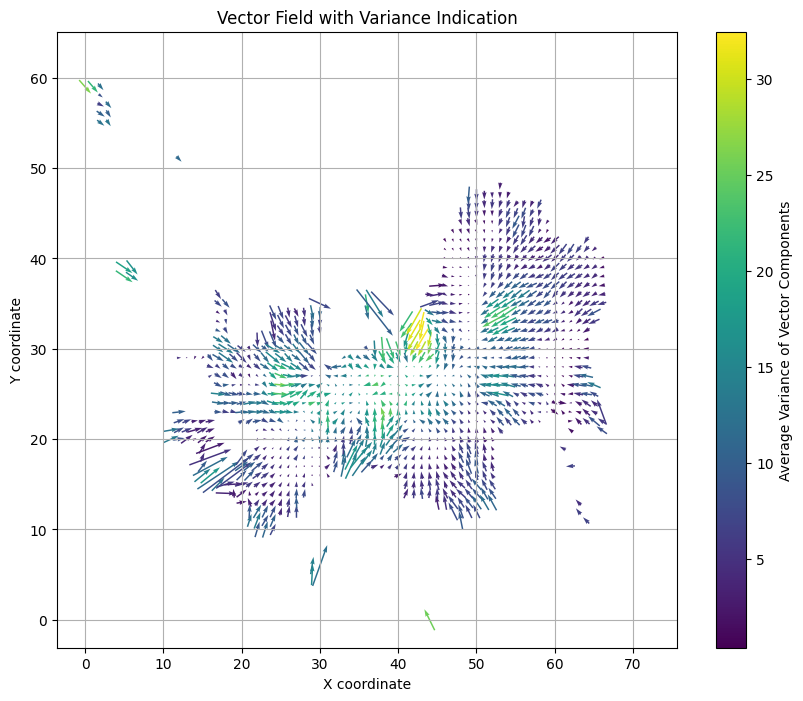

In [14]:
smoothed = process_df(tx, 0,1)
mu_dx,mu_dy,var_dx,var_dy = dataframe_to_grid(smoothed)
mu_dx,mu_dy,var_dx,var_dy = apply_spatial_smoothing(mu_dx,mu_dy,var_dx,var_dy,1)
averaged = grid_to_dataframe(mu_dx,mu_dy,var_dx_grid=var_dx,var_dy_grid=var_dy)
plot_vector_field_with_var(averaged,2)

In [15]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.ndimage import generic_filter
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

class DiscreteVectorFieldAnalyzer:
    def __init__(self, df, interpolation_factor=1):
        self.df = df
        self.interpolation_factor = interpolation_factor
        self._prepare_data()

    def _prepare_data(self):
        # Extract original data
        x = self.df['from_x'].values
        y = self.df['from_y'].values
        u = self.df['mu_dx'].values
        v = self.df['mu_dy'].values
        
        # Create fine grid
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        self.x_fine = np.linspace(x_min, x_max, int((x_max - x_min) * self.interpolation_factor))
        self.y_fine = np.linspace(y_min, y_max, int((y_max - y_min) * self.interpolation_factor))
        self.X_fine, self.Y_fine = np.meshgrid(self.x_fine, self.y_fine)
        
        # Prepare points for interpolation
        points = np.column_stack((x, y))
        
        # Create Delaunay triangulation for the original points
        tri = Delaunay(points)
        
        # Interpolate U and V using LinearNDInterpolator
        self.U_interp = LinearNDInterpolator(points, u, fill_value=np.nan)
        self.V_interp = LinearNDInterpolator(points, v, fill_value=np.nan)
        
        # Apply interpolation
        self.U_fine = self.U_interp(self.X_fine, self.Y_fine)
        self.V_fine = self.V_interp(self.X_fine, self.Y_fine)
        
        # Create mask for valid data points
        # fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        # self.valid_mask = tri.find_simplex(fine_points) >= 0
        # self.valid_mask = self.valid_mask.reshape(self.X_fine.shape)

        # Create a more restrictive mask for valid data points
        fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        in_simplex = tri.find_simplex(fine_points) >= 0
        has_valid_values = ~np.isnan(self.U_fine.ravel()) & ~np.isnan(self.V_fine.ravel())
        self.valid_mask = (in_simplex & has_valid_values).reshape(self.X_fine.shape)
        
        # Apply mask to U_fine and V_fine
        self.U_fine[~self.valid_mask] = np.nan
        self.V_fine[~self.valid_mask] = np.nan
        
        self.grid_shape = self.X_fine.shape


    def generate_trajectory(self, start_index, max_steps=1000, step_size=0.1):
        trajectory = [start_index]
        current_point = np.array([self.X_fine[start_index[0], start_index[1]], 
                                  self.Y_fine[start_index[0], start_index[1]]])
        visited = set([start_index])
        
        for _ in range(max_steps):
            i, j = self.discretize_point(current_point)
            if not self.valid_mask[i, j]:
                print("We are out of bounds")
                
            delta = self.vector_field(i, j)
            
            if np.all(np.abs(delta) < 1e-6):
                break  # Stopping point detected
            
            # Euler integration step
            next_point = current_point + delta * step_size
            
            # Discretize the new point to get the next grid index
            next_index = self.discretize_point(next_point)
            
            if not (0 <= next_index[0] < self.grid_shape[0] and 0 <= next_index[1] < self.grid_shape[1]):
                break  # Out of bounds

            if not self.valid_mask[next_index[0], next_index[1]]:
                break 
            
            if next_index in visited:
                break  # Cycle detected
            
            visited.add(next_index)
            trajectory.append(next_index)
            current_point = next_point
        
        return trajectory


    def process_point(self, args):
        index, step_size = args
        trajectory = self.generate_trajectory(index, step_size=step_size)
        return trajectory

    def analyze_vector_field(self, step_size=0.1):
        valid_indices = list(zip(*np.where(self.valid_mask)))
        
        # Create a list of tuples containing both the index and step_size
        args = [(index, step_size) for index in valid_indices]
        
        with mp.Pool() as pool:
            trajectories = pool.map(self.process_point, args)


        
        
        return trajectories


    def discretize_point(self, point):
        """Convert a continuous point to the nearest grid index."""
        j = np.clip(np.searchsorted(self.x_fine, point[0]), 0, self.grid_shape[1] - 1)
        i = np.clip(np.searchsorted(self.y_fine, point[1]), 0, self.grid_shape[0] - 1)
        return (int(i), int(j))
        
   

    def vector_field(self, i, j):
        """Return the vector field at the given grid indices."""
        return np.array([self.U_fine[i, j], self.V_fine[i, j]])

 
    def find_attractors_and_basins(self, trajectories, min_quality=10, threshold=0.1, samples=5):
        valid_indices = list(zip(*np.where(self.valid_mask)))
        # Convert indices to coordinates for clustering
        end_indices = [t[-1] for t in trajectories]
        end_points = np.array([(self.X_fine[i, j], self.Y_fine[i, j]) for i, j in end_indices])
        
        clustering = DBSCAN(eps=threshold, min_samples=samples).fit(end_points)
        
        unique_labels = np.unique(clustering.labels_)
        print(f"Unique labels: {unique_labels}")
        attractors = []
        valid_labels = {}  # Dictionary to map DBSCAN labels to new attractor indices
        new_label = 0  # Counter for new labels
        
        for label in unique_labels:
            if label != -1:  # -1 is noise in DBSCAN
                cluster_points = end_points[clustering.labels_ == label]
                quality = 0
                cluster_indices = np.where(clustering.labels_ == label)[0]
                for idx in cluster_indices:
                    quality += len(trajectories[idx])
                if quality > min_quality:
                    attractors.append(np.mean(cluster_points, axis=0))
                    valid_labels[label] = new_label
                    new_label += 1
        
        attractors = np.array(attractors)
        print(f"Number of attractors after pruning: {len(attractors)}")
        
        # Assign basins
        basins = np.full(self.grid_shape, -1, dtype=int)
        for (i, j), label in zip(valid_indices, clustering.labels_):
            basins[i, j] = valid_labels.get(label, -1)
        
        # Fill pruned basins with nearest valid basin
        valid_points = []
        valid_labels_list = []
        for i, j in valid_indices:
            if basins[i, j] != -1:
                valid_points.append((self.X_fine[i, j], self.Y_fine[i, j]))
                valid_labels_list.append(basins[i, j])
        
        if not valid_points:
            print("Warning: All attractors were pruned.")
            return attractors, basins  # Return if no valid points (all attractors pruned)
        
        tree = cKDTree(valid_points)
        
        pruned_points = []
        pruned_indices = []
        for i, j in valid_indices:
            if basins[i, j] == -1:
                pruned_points.append((self.X_fine[i, j], self.Y_fine[i, j]))
                pruned_indices.append((i, j))
        
        if pruned_points:
            distances, indices = tree.query(pruned_points, k=1)
            for (i, j), idx in zip(pruned_indices, indices):
                basins[i, j] = valid_labels_list[idx]
        
        return attractors, basins

    def plot_results(self, attractors, basins):
        plt.figure(figsize=(12, 10))
        masked_basins = np.ma.masked_where(~self.valid_mask, basins)
        plt.imshow(masked_basins, extent=[self.x_fine.min(), self.x_fine.max(), 
                                          self.y_fine.min(), self.y_fine.max()],
                   origin='lower', alpha=0.6, cmap='viridis')
        plt.streamplot(self.X_fine, self.Y_fine, self.U_fine, self.V_fine, 
                       density=3, color='gray', arrowsize=0.5)
        plt.scatter(attractors[:, 0], attractors[:, 1], c='red', s=100, label='Attractors')
        plt.colorbar(label='Basin of Attraction')
        plt.title('Vector Field with Basins of Attraction')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.show()

In [16]:
analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=4)
trajectories = analyzer.analyze_vector_field(step_size=.8)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 389, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'DiscreteVectorFieldAnalyzer' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiproce

KeyboardInterrupt: 

In [ ]:
attractors, basins = analyzer.find_attractors_and_basins(trajectories,min_quality=40,threshold=1,samples=5)
analyzer.plot_results(attractors,basins)